In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

In [2]:
#installing pytorch
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


In [3]:
# Auto-iterate through all files that matches this query
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: model, id: 1pInhBXldeRAvBlphQvy5dh6iPE7DtYA2
title: data, id: 1-XYATwD6zIEM-qhuf0_G6bbmTYIDn8D7
title: ib-urls.zip, id: 1iPo3Q40Q1oD1jBfHLZ_HM8OFPklw5A4h
title: Studium, id: 1dYS9oGXR9XIa0QcCa_Zg7va8h683Ysmg
title: Colab Notebooks, id: 10mmCLukHlljr19RsTs2m1G8T4dxuyFl7
title: AVA_dataset, id: 1oVS33eo7pCFlW1VJ5FNbXuIuAFqGxzDW
title: 3. Semester Planung, id: 1YKwNLfMrIZ4iUkNMva-rFS9QsX3YBGM3YOw3lX9Hm_M
title: Unbenannter Bericht, id: 0B_7yoBKo6x0tUXVfVDRYZVZPSDQ
title: Unbenannte Tabelle, id: 1wRHcz7JhA4kuKo_pcM3NT4qPIB85wFzoTWSLfiSzGW0
title: Studierfähigkeitstest für den Studiengang IT-Systems Engineering im Bachelor am Hasso-Plattner-Institut, id: 1H9ldD_AQWHJode3Eh14V7HiYlQQ9SZ84ipysY1Ik20o
title: Ib, id: 0B_7yoBKo6x0tNnVINmVpY2ZZNjA
title: Meine Orte.kmz, id: 0B_7yoBKo6x0tVzJKNnNZQWhxOE5RZDdacm04WThIc2VDNXBV


In [21]:
# Auto-iterate through all files that matches this query
file_list = drive.ListFile(
    {'q': "'1-XYATwD6zIEM-qhuf0_G6bbmTYIDn8D7' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: tiny_shakespeare.txt, id: 1bZkY01oi6uojjmYr85kW1W9PLf9p5okR


In [22]:
# models fodler
file_list = drive.ListFile(
    {'q': "'1pInhBXldeRAvBlphQvy5dh6iPE7DtYA2' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: tiny_Shakespeare_LSTM_512.pkl, id: 1CsrXv5JcG6SRse2mBnKje4M9f6LwBF4X
title: tiny_Shakespeare_LSTM_512.pkl, id: 10e85GXNywdxrpwb-BG4Qv-AQvQsKO5pk


In [5]:
# 3. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': '1bZkY01oi6uojjmYr85kW1W9PLf9p5okR'})
text = downloaded.GetContentString()
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [0]:
def save_to_drive_folder(folder_id, filename):
  q_str = "'{}' in parents and trashed=false".format(folder_id)
  file_list = drive.ListFile({'q': q_str}).GetList()
  for file in file_list:
    if file['title'] == filename:
      found = True
      print("file found in drive; overwriting", end=" ")
      break
  else:
    found = False
    print("file not found in drive; creating new file")
  
  if not found:
    file = drive.CreateFile({"parents": [{"kind": "drive#fileLink", 
                                          "id": folder_id}]})#{'title': 'tiny_Shakespeare_LSTM_512.pkl'})
  file.SetContentFile(filename)
  file.Upload()
  print('Uploaded file with ID {}'.format(file.get('id')))

In [7]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

torch.manual_seed(1338)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [0]:
def encode_text(line,dict_):
    vec = np.zeros((len(line),len(dict_)),dtype="uint8")
    for i, char in enumerate(line):
        vec[i][dict_[char]] = 1
    
    return vec

In [0]:
class EncodedCharDataset(torch.utils.data.Dataset):
    """Char based, one hot encoded dataset with continous sampling"""

    def __init__(self, text, seq_len, char_to_idx={},idx_to_char={}):
        """
        Args:
            file: filepath
            seq_len: lenght of sample the dataset will return
        """
        self.offset = 0
        
        # length of sample sequences
        self.seq_len = seq_len
        
        # char to id; Encoding dict
        self.char_to_idx = char_to_idx
        # id to char; Decoding dict
        self.idx_to_char = idx_to_char
        

        self.data = np.empty(len(text))
        # fill dicts
        for i, char in enumerate(text): 
                if char not in self.char_to_idx:
                    id_ = len(self.char_to_idx)
                    # add char to dicts
                    self.char_to_idx[char] = id_
                    self.idx_to_char[id_] = char

                # Encode and store text from file in self.data
                self.data[i] = self.char_to_idx[char]


        self.data = np.array(self.data,dtype="uint8")
        
        self.unique_chars = len(self.char_to_idx)
        print("#different chars:", self.unique_chars)
        
        
        
    def __len__(self):
        return (len(self.data)) // self.seq_len #- (self.seq_len-1) #

    def __getitem__(self, i):
        """
        returns (self.seq_len,self.unique_chars) one hot vectors 
        """
        indices = self.data[i*self.seq_len:(i+1)*self.seq_len] #[i:i+self.seq_len]#
        x_onehot = torch.zeros((self.seq_len,self.unique_chars))
        x_onehot[np.arange(self.seq_len), indices] = 1
        
        inputs = x_onehot[:-1,:]
        targets = torch.argmax(x_onehot[1:,:],dim=-1)
        return inputs, targets
    


In [0]:
val_size = 2000

val_text = text[-val_size:]
test_text = text[:-val_size]

In [12]:
seq_len = 129
batch_size = 1
kwargs = {'num_workers': 1, 
          'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 2}
train_dataset = EncodedCharDataset(text=test_text,seq_len=seq_len)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=seq_len,
                                           shuffle=True, **kwargs)

val_dataset = EncodedCharDataset(text=val_text,seq_len=len(val_text),
                                 char_to_idx=train_dataset.char_to_idx,
                                 idx_to_char=train_dataset.idx_to_char)
#val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
#                                           shuffle=False, **kwargs)

assert(train_dataset.unique_chars == val_dataset.unique_chars)
num_classes = train_dataset.unique_chars

#different chars: 65
#different chars: 65


In [0]:
class CharLSTM(torch.nn.Module):
    def __init__(self,input_size,hidden_size,output_size, num_layers=1,
                 dropout=0,batch_first=True):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.GRU(input_size, hidden_size, 
                           num_layers=num_layers,
                           dropout=dropout,
                           batch_first=batch_first)
        self.lin = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs, hidden=None, force=False, steps=0):
        output, hidden = self.lstm(inputs, hidden)
        output = self.lin(output)

        return output, hidden
      
    def init_hidden(self, batch_size=1):
      return torch.zeros((self.num_layers, batch_size, self.hidden_size))

In [0]:
def gen_text(model, init_seq="There is", temperature=.9,
               lenght=250,
               idx_to_char=train_dataset.idx_to_char, 
               char_to_idx=train_dataset.char_to_idx):
    """
    generates text of length lenght from model using start_char to initialize hidden state and 
    """
    model.eval()
    with torch.no_grad():
      hidden = model.init_hidden()
      
      if torch.cuda.is_available():
          hidden = hidden.cuda()
      
      # initialize hidden state with start_char seqence
      for chr in init_seq:
          # encode the initialization sequence
          input = torch.zeros((1,1,num_classes),dtype=torch.float)
          input[0][0][char_to_idx[chr]] = 1 
          
          if torch.cuda.is_available():
            input = input.cuda()
            
          output,hidden = model(input,hidden)
      
      # generate new seqence 
      text = ""
      while len(text) < lenght:
          # prob output to one hot encoded vector
          probs = nn.Softmax(dim=-1)(output).detach().cpu().numpy()[0,0]
          
          # choose next char
          char_id = sample(probs,temperature)#output.argmax(dim=-1).item()
          
          # one-hot encode new char for new input to model 
          input = torch.zeros((1,1,num_classes),dtype=torch.float)
          input[0][0][char_id] = 1 
          
          if torch.cuda.is_available():
            input = input.cuda()
          
          output, hidden = model(input,hidden)
          
          # decode generated char and add to string
          text += idx_to_char[char_id]
    return text

def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array a
    a = np.log(a) / temperature
    a = np.exp(a) / np.sum(np.exp(a))
    return np.random.choice(range(num_classes),p=a)

In [0]:
def train(inputs,targets):
  """
  trains the model step by step for a batch of inputs of shape 
  (batch_size, seq_len, num_classes) and targets of shape ******
  """
  model.train()
  optimizer.zero_grad()
  loss = 0
  hidden = model.init_hidden(batch_size=inputs.shape[0])
  
  if torch.cuda.is_available():
      inputs, targets, hidden = inputs.cuda(), targets.cuda(), hidden.cuda()

  for i in range(inputs.shape[1]):
    out,hidden = model(inputs[:,i:i+1,:],hidden)
    loss += criterion(out.permute(dims=(0,2,1)), targets[:,i:i+1])

  loss.backward()
  optimizer.step()
  return loss.item() / inputs.shape[1] 

In [0]:
def evaluate(inputs, targets):
    """
    evaluates the model step by step for a batch of inputs of shape 
    (seq_len, num_classes) and targets of shape *****
    """
    model.eval()
    loss = 0
    with torch.no_grad():
      inputs = inputs.expand(1,-1,-1)
      #print(inputs.shape)
      targets = targets.expand(1,-1)
      #print(targets.shape)
      hidden = model.init_hidden(batch_size=inputs.shape[0])

      if torch.cuda.is_available():
          inputs, targets, hidden = inputs.cuda(), targets.cuda(), hidden.cuda()

      for i in range(inputs.shape[1]):
        out,hidden = model(inputs[:,i:i+1,:], hidden)
        loss += criterion(out.permute(dims=(0,2,1)), targets[:,i:i+1])

    return loss.item() / inputs.shape[1] 

In [0]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    print("saving model")
    torch.save(state, filename)
      
    #if is_best:
    #    shutil.copyfile(filename, 'model_best.pth.tar')
    
def load_checkpoint(filename):
    if os.path.isfile(filename):
        global start_epoch
        global best_val
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        best_val = checkpoint['best_val']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler = checkpoint['scheduler']
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

In [0]:
input_size = num_classes
hidden_size = 256
output_size = num_classes
num_layers = 2
dropout = 0.15
filename = 'shakesbeare_checkpoint.pth.tar'

model = CharLSTM(input_size=input_size,hidden_size=hidden_size,
                 output_size=output_size,num_layers=num_layers,
                 dropout=dropout,batch_first=True)

if torch.cuda.is_available():
    model.cuda()

In [0]:
start_epoch = 1
best_val = 1000
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',
                                                 verbose=True)


losses = []
mean_losses = []
val_losses = []

In [82]:
# Load model from checkpoint
# TODO: load directly from google drive
load_checkpoint(filename)

=> loading checkpoint 'shakesbeare_checkpoint.pth.tar'
=> loaded checkpoint 'shakesbeare_checkpoint.pth.tar' (epoch 1)



Epoch 1:
Loss: 1.31776 | Running loss: 1.30504, Batch: 60       
Mean Loss: 1.297966257849736

Validation Loss: 1.33889 | Prev best: 1.34216


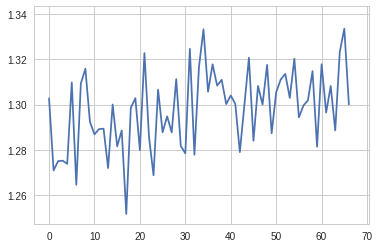

saving model
file found in drive; overwriting Uploaded file with ID 1D-_786xtrwgWcMoFLNDQkGghPH7ay-g4

Epoch 2:
Loss: 1.29241 | Running loss: 1.29788, Batch: 60       
Mean Loss: 1.288322133804435

Validation Loss: 1.33468 | Prev best: 1.33889


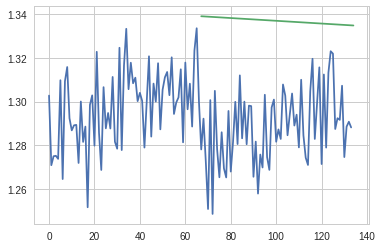

saving model
file found in drive; overwriting Uploaded file with ID 1D-_786xtrwgWcMoFLNDQkGghPH7ay-g4

Epoch 3:
Loss: 1.26116 | Running loss: 1.27367, Batch: 20       

Process Process-17:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f98ef8309b0

KeyboardInterrupt: ignored

In [85]:
# training LSTM
for epoch in range(start_epoch, 300):
    print("\nEpoch {}:".format(epoch))
    # train epoch
    losses.append([])
    for batch, (inputs, targets) in enumerate(train_loader):
        losses[-1].append(train(inputs, targets))
        
        if batch % 10 == 0:
            rmean_loss = np.mean(losses[-1][-15:])
            print("\rLoss: {:.5f} | Running loss: {:.5f}, Batch: {}       "
                  .format(losses[-1][-1],rmean_loss,batch), end="")
        #if batch % 200 == 0: 
        #  print(gen_text(model))
        #  model.train()
    
    mean_loss = np.mean(losses[-1])
    mean_losses.append(mean_loss)
    print("\nMean Loss:", mean_loss)
    
    # validate    
    val_loss = evaluate(*val_dataset[0])
    val_losses.append(val_loss)
    print("\nValidation Loss: {:.5f} | Prev best: {:.5f}".format(val_loss, best_val))
    
    scheduler.step(val_loss)
    
    # Plot training progress / batchwise train error and val_loss
    fig = plt.figure()
    ax = plt.axes()
    # flatten losses array
    flat_losses = [item for sublist in losses for item in sublist]
    # get corresponding x-axis positions for the val error
    val_losses_x = []
    x = 0
    for sublist in losses:
      x += len(sublist)
      val_losses_x.append(x)
    #val_losses_x = [len(sublist) for sublist in losses]
    ax.plot(range(len(flat_losses)), flat_losses)
    ax.plot(val_losses_x, val_losses)
    plt.show()
    
    # Model saving
    is_best = val_loss < best_val
    if is_best:
        # save model if validation error is minimal
        best_val = val_loss
        save_checkpoint({
                'epoch':  epoch + 1,
                'state_dict': model.state_dict(),
                'best_val': val_loss,
                'optimizer' : optimizer.state_dict(),
                'scheduler': scheduler,
            }, is_best, filename)
    
    # save model to google drive 
    save_to_drive_folder('1pInhBXldeRAvBlphQvy5dh6iPE7DtYA2',filename)
    
    if epoch % 10 == 0 and epoch > 0:
        # show some example by the curren model
        print("Samples with increasing Temp -> conservative first:")
        for i in range(5):
            temp = 0.2*(i+1)
            print("Temprature: ", temp)
            print(gen_text(model,temperature=temp))

In [0]:
import os

In [40]:
os.listdir(".")

['.config',
 'datalab',
 'sample_data',
 'adc.json',
 'shakesbeare_checkpoint.pth.tar']

In [44]:
load_checkpoint('shakesbeare_checkpoint.pth.tar')

=> loading checkpoint 'shakesbeare_checkpoint.pth.tar'
=> loaded checkpoint 'shakesbeare_checkpoint.pth.tar' (epoch 1)
